# Predict the Introverts from the Extroverts

## 1. Introduction

### 🧠 Project Overview

This project is part of the Playground Series (Season 5, Episode 7) hosted on Kaggle. The goal is to build a machine learning model that can distinguish introverts from extroverts based on given features derived from behavioral, demographic, or psychological data.

The challenge is a binary classification task — predicting whether an individual falls into the Introvert (0) or Extrovert (1) category.

## 2.Importing Libraries & Environment Setup

### This block is tailored for a binary classification project and includes preprocessing utilities, common classifiers, model-selection tools, and classification metrics.

In [196]:
# Basics
import math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & utilities
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model selection & tuning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# Classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics (classification)
from sklearn.metrics import (
accuracy_score,
precision_score,
recall_score,
f1_score,
roc_auc_score,
confusion_matrix,
classification_report
)

## 3. Loading and Exploring Data

### Data Files                                                                         train.csv — training data with features and target                                       test.csv — test data for predictions                                       sample_submission.csv — example submission file

In [197]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Quick view
print(f"the train shape {train.shape}")
print(f"the test shape {test.shape}")
print(f"the sample_submission shape {sample_submission.shape}") 

the train shape (18524, 9)
the test shape (6175, 8)
the sample_submission shape (6175, 2)


## Exploratory Data Analysis (EDA)

In [198]:
train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [199]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [200]:
train.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [201]:
train.isnull().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [202]:
# Check class balance
target_counts = train['Personality'].value_counts()
print(target_counts)

Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64


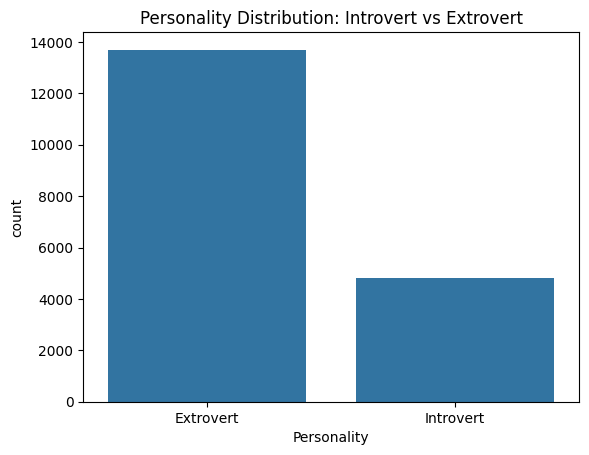

In [203]:
# Visualization
sns.countplot(x='Personality', data=train)
plt.title('Personality Distribution: Introvert vs Extrovert')
plt.show()

In [204]:
test.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [205]:
test.isnull().sum()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

In [206]:
print(f'The unique types for train: {train.dtypes.unique().tolist()}')
print(f'The unique types for test: {test.dtypes.unique().tolist()}')

The unique types for train: [dtype('int64'), dtype('float64'), dtype('O')]
The unique types for test: [dtype('int64'), dtype('float64'), dtype('O')]


In [207]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
len(num_cols)

6

In [208]:
cat_cols = train.select_dtypes(include=['object']).columns
len(cat_cols)

3

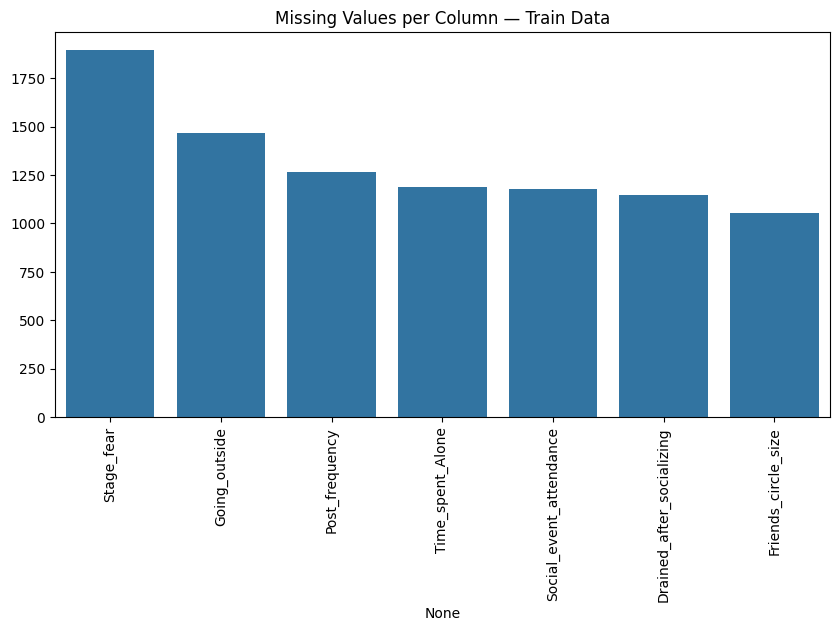

In [209]:
# Missing values in train
missing_train = train.isnull().sum().sort_values(ascending=False)
missing_train = missing_train[missing_train > 0]
if not missing_train.empty:
    plt.figure(figsize=(10,5))
    sns.barplot(x=missing_train.index, y=missing_train.values)
    plt.xticks(rotation=90)
    plt.title("Missing Values per Column — Train Data")
    plt.show()

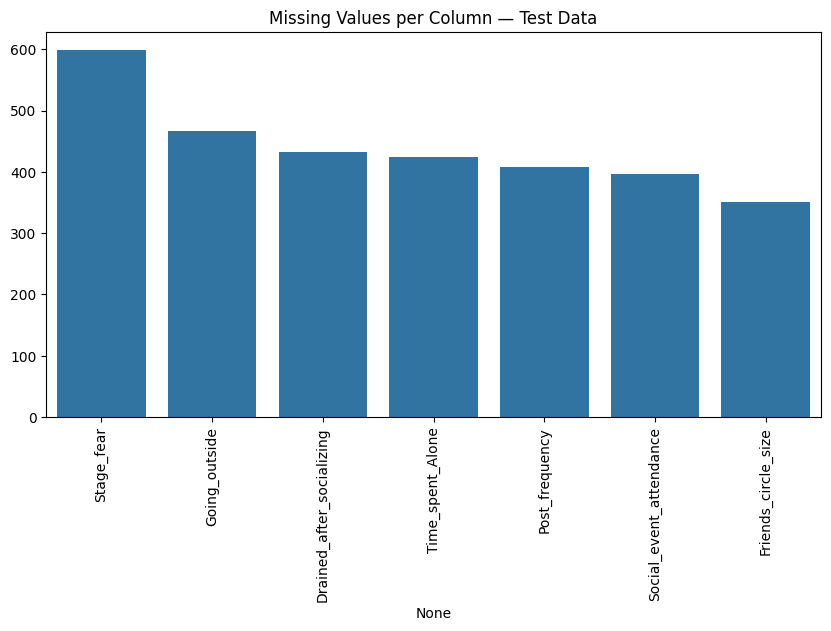

In [210]:
# Missing values in test
missing_test = test.isnull().sum().sort_values(ascending=False)
missing_test = missing_test[missing_test > 0]
if not missing_test.empty:
    plt.figure(figsize=(10,5))
    sns.barplot(x=missing_test.index, y=missing_test.values)
    plt.xticks(rotation=90)
    plt.title("Missing Values per Column — Test Data")
    plt.show()

In [211]:
train.isnull().sum().sort_values(ascending=False)

Stage_fear                   1893
Going_outside                1466
Post_frequency               1264
Time_spent_Alone             1190
Social_event_attendance      1180
Drained_after_socializing    1149
Friends_circle_size          1054
id                              0
Personality                     0
dtype: int64

In [212]:
test.isnull().sum().sort_values(ascending=False)

Stage_fear                   598
Going_outside                466
Drained_after_socializing    432
Time_spent_Alone             425
Post_frequency               408
Social_event_attendance      397
Friends_circle_size          350
id                             0
dtype: int64

In [213]:
train['Time_spent_Alone'].describe()


count    17334.000000
mean         3.137764
std          3.003786
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         11.000000
Name: Time_spent_Alone, dtype: float64

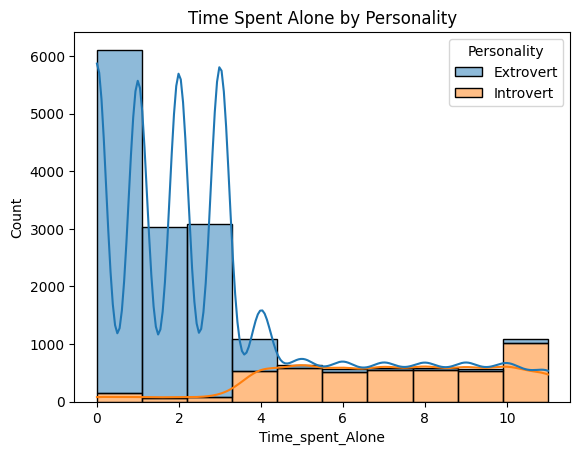

In [214]:
sns.histplot(data=train, x='Time_spent_Alone', hue='Personality', bins=10, kde=True, multiple='stack')
plt.title('Time Spent Alone by Personality')
plt.show()


In [215]:
print(train['Going_outside'].unique())


[ 4.  3.  0.  5. nan  1.  6.  2.  7.]


In [216]:
print("MAX:", train['Going_outside'].max())
print("MIN:", train['Going_outside'].min())


MAX: 7.0
MIN: 0.0


In [217]:
train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [218]:
print("MAX:", train['Friends_circle_size'].max())
print("MIN:", train['Friends_circle_size'].min())


MAX: 15.0
MIN: 0.0


In [219]:
print("MAX:", train['Post_frequency'].max())
print("MIN:", train['Post_frequency'].min())

MAX: 10.0
MIN: 0.0


In [220]:
# Check class balance
target_counts = train['Personality'].value_counts()
print(target_counts)

Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64


## 4. Data Preprocessing / Cleaning

### Missing Values Analysis

First, let's check how many missing values are present in each column of our dataset.



In [221]:
missing_percent = train.isnull().mean() * 100
print(missing_percent)

id                            0.000000
Time_spent_Alone              6.424098
Stage_fear                   10.219175
Social_event_attendance       6.370114
Going_outside                 7.914057
Drained_after_socializing     6.202764
Friends_circle_size           5.689916
Post_frequency                6.823580
Personality                   0.000000
dtype: float64


### 🧹 Handling Missing Values

In this step, we handle all missing values in both train and test datasets. We create a reusable function that can be applied to any DataFrame.

In [222]:
def handle_missing(df):
    """
    Fill missing values in the DataFrame:
    - Numeric columns: median
    - Categorical columns: most frequent (mode)
    """
    df = df.copy()
    # Separate numerical and categorical columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    # Impute numerical columns with median
    if len(num_cols) > 0:
        num_imputer = SimpleImputer(strategy='median')
        df[num_cols] = num_imputer.fit_transform(df[num_cols])
    # Impute categorical columns with most frequent value
    if len(cat_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    return df

In [223]:
train_clean = handle_missing(train)
test_clean = handle_missing(test)

In [224]:
train_clean.isnull().sum()

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [225]:
test_clean.isnull().sum()

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
dtype: int64

In [226]:
print(f'the train shape {train.shape}')
print(f'the test shape {test.shape}')

the train shape (18524, 9)
the test shape (6175, 8)


In [227]:
missing_after = train_clean.isnull().sum().sum()
print(f"Total missing values after cleaning: {missing_after}")

Total missing values after cleaning: 0


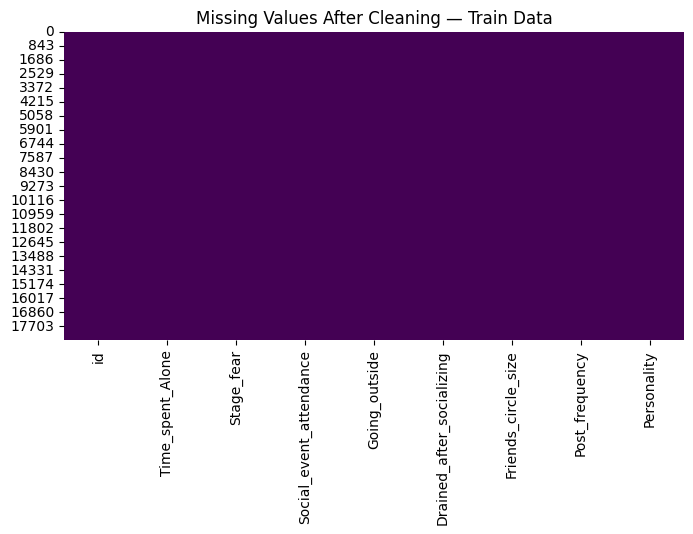

In [228]:
plt.figure(figsize=(8, 4))
sns.heatmap(train_clean.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values After Cleaning — Train Data")
plt.show()

## 5. Encoding Categorical Columns

### 🎯 Purpose

Convert categorical columns and target variable into numeric 0/1 values for modeling. This is a simple and clean approach suitable for Logistic Regression.

In [229]:
def encode_binary_features(df):
    """
    Encode categorical features and target variable as 0/1.
    - Stage_fear: Yes=1, No=0
    - Drained_after_socializing: Yes=1, No=0
    - Personality (target): Extrovert=1, Introvert=0
    """
    df = df.copy()

    # Encode categorical features
    df['Stage_fear'] = df['Stage_fear'].map({'Yes': 1, 'No': 0})
    df['Drained_after_socializing'] = df['Drained_after_socializing'].map({'Yes': 1, 'No': 0})
    
    # Encode target variable if present
    if 'Personality' in df.columns:
        df['Personality'] = df['Personality'].map({'Extrovert': 1, 'Introvert': 0})
    return df

In [230]:
train_encoded = encode_binary_features(train_clean)
test_encoded = encode_binary_features(test_clean)

## 6. Checking Feature Skewness

### 🎯 Purpose

Assess the skewness of selected features to understand if the distribution is symmetric or skewed. This helps decide if transformations are needed before modeling.

### 🔎 Notes

skew ≈ 0 → approximately symmetric distribution

skew > 0 → right-skewed (long tail to the right)

skew < 0 → left-skewed (long tail to the left)

If |skew| > 1 → strongly skewed, consider transformations like log

In [231]:
# List of features
features = [
'Stage_fear',
'Drained_after_socializing',
'Time_spent_Alone',
'Social_event_attendance',
'Going_outside',
'Friends_circle_size',
'Post_frequency'
]


# Check skewness and plot distributions
for col in features:
    skew_val = train_encoded[col].skew()
    print(f"{col}: skewness = {skew_val:.2f}")
    # plt.figure(figsize=(6,4))
    # sns.histplot(train_encoded[col], kde=True, bins=20)
    # plt.title(f"Distribution of {col} (skew = {skew_val:.2f})")
    # plt.show()

Stage_fear: skewness = 1.37
Drained_after_socializing: skewness = 1.36
Time_spent_Alone: skewness = 1.23
Social_event_attendance: skewness = -0.22
Going_outside: skewness = -0.38
Friends_circle_size: skewness = -0.05
Post_frequency: skewness = -0.06


In [232]:
train_encoded['Time_spent_Alone_log'] = np.log1p(train_encoded['Time_spent_Alone'])
test_encoded['Time_spent_Alone_log'] = np.log1p(test_encoded['Time_spent_Alone'])

## 7. Feature Engineering

### 🎯 Purpose

Create simplified yet powerful features that intuitively capture social behavior and personality traits. These features combine existing variables into meaningful indicators to help the model distinguish Introverts from Extroverts.

### Social_Engagement_Score 🚶‍♂️

Logic: Measures overall social activity by combining positive social factors and reducing by time spent alone.
Meaning: Higher value → more socially engaged/extroverted.

In [233]:

train_encoded['Social_Engagement_Score'] = (
    train_encoded['Social_event_attendance'] +
    train_encoded['Friends_circle_size'] +
    train_encoded['Going_outside']
) - train_encoded['Time_spent_Alone_log']


test_encoded['Social_Engagement_Score'] = (
    test_encoded['Social_event_attendance'] +
    test_encoded['Friends_circle_size'] +
    test_encoded['Going_outside']
) - test_encoded['Time_spent_Alone_log']

### Public_Avoidance 🤫

Logic: Combines social anxiety and avoidance behaviors.

Formula: Going_outside is on a scale 1-5
Meaning: Higher value → more avoidance and social withdrawal.

In [234]:
train_encoded['Public_Avoidance'] = train_encoded['Stage_fear'] + (5 - train_encoded['Going_outside'])
test_encoded['Public_Avoidance'] = test_encoded['Stage_fear'] + (5 - test_encoded['Going_outside'])

In [235]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  float64
 1   Time_spent_Alone           18524 non-null  float64
 2   Stage_fear                 18524 non-null  int64  
 3   Social_event_attendance    18524 non-null  float64
 4   Going_outside              18524 non-null  float64
 5   Drained_after_socializing  18524 non-null  int64  
 6   Friends_circle_size        18524 non-null  float64
 7   Post_frequency             18524 non-null  float64
 8   Personality                18524 non-null  int64  
 9   Time_spent_Alone_log       18524 non-null  float64
 10  Social_Engagement_Score    18524 non-null  float64
 11  Public_Avoidance           18524 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 1.7 MB


## 8. Feature Scaling (Updated)

### 🎯 Purpose

Standardize all non-binary numerical features to ensure Logistic Regression works efficiently and coefficients are comparable. Binary features (0/1) and ID/target columns are left unchanged.


In [236]:
# List of non-binary numerical features
features_to_scale = [
'Time_spent_Alone_log',
'Social_event_attendance',
'Going_outside',
'Friends_circle_size',
'Post_frequency',
'Public_Avoidance'
]

# Initialize scaler
scaler = StandardScaler()

# Fit on train data and transform
train_encoded[features_to_scale] = scaler.fit_transform(train_encoded[features_to_scale])

# Transform test data using the same scaler
test_encoded[features_to_scale] = scaler.transform(test_encoded[features_to_scale])

## 9. Logistic Regression

### 🎯 Purpose

Train a baseline Logistic Regression model to classify individuals as Introverts (0) or Extroverts (1). Use cross-validation to assess stability and final evaluation on test set.

### 1️⃣ Prepare Features and Target

In [237]:
# Features (exclude id and target)
X = train_encoded.drop(columns=['id', 'Personality'])
y = train_encoded['Personality']


# Test features
X_test = test_encoded.drop(columns=['id'])

### 2️⃣ Cross-Validation

In [238]:
# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy')

print(f'Cross-validated accuracy scores: {scores}')
print(f'Mean CV accuracy: {scores.mean():.4f}')

Cross-validated accuracy scores: [0.96896086 0.96707152 0.965722   0.9705803  0.97138229]
Mean CV accuracy: 0.9687


### 3️⃣ Train on Full Train Set and Predict on Test

In [239]:
# Fit model on all training data
logreg.fit(X, y)

# Predict on test set
predictions = logreg.predict(X_test)

### 4️⃣ Evaluate Logistic Regression on Train Set (Optional)

In [240]:
# Train set predictions
train_preds = logreg.predict(X)

# Metrics
print('Train Accuracy:', accuracy_score(y, train_preds))
print('Train F1 Score:', f1_score(y, train_preds))
print('Train ROC-AUC:', roc_auc_score(y, train_preds))

# Confusion matrix
cm = confusion_matrix(y, train_preds)
print('Confusion Matrix:\n', cm)

Train Accuracy: 0.9687972360181386
Train F1 Score: 0.9789481351981352
Train ROC-AUC: 0.9575568883474342
Confusion Matrix:
 [[ 4507   318]
 [  260 13439]]


### 5️⃣ Submission File

In [241]:
# Convert numeric predictions to required string labels
preds_labels = np.where(predictions == 1, 'Extrovert', 'Introvert')

submission = pd.DataFrame({
    'id': test_encoded['id'],
    'Personality': preds_labels
})

submission.to_csv('submission_logistic_regression.csv', index=False)
print("✅ submission_logistic_regression.csv created")

✅ submission_logistic_regression.csv created


## 10. Random Forest

### 🎯 Purpose

Train a Random Forest classifier as a stronger, non-linear baseline. Evaluate with cross-validation, inspect feature importance, and create a Kaggle submission (with labels Extrovert / Introvert).

### 1️⃣ Prepare data

In [242]:
# Features and target
X = train_encoded.drop(columns=['id', 'Personality'])
y = train_encoded['Personality']


# Align test columns with train features
X_test = test_encoded.drop(columns=['id']).reindex(columns=X.columns)

### 2️⃣ Quick checks

In [243]:
# Sanity checks
assert X.isnull().sum().sum() == 0, 'Missing values in X'
assert X_test.isnull().sum().sum() == 0, 'Missing values in X_test'
assert X_test.shape[1] == X.shape[1], 'Feature mismatch between train and test'

### 3️⃣ Baseline Random Forest with CV

In [244]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')

print('RF CV scores:', scores)
print('Mean RF CV accuracy: %.4f (std %.4f)' % (scores.mean(), scores.std()))

RF CV scores: [0.96437247 0.96383266 0.9611336  0.96653171 0.96463283]
Mean RF CV accuracy: 0.9641 (std 0.0017)


### 4️⃣ Fit on full train and predict on test

In [245]:
# Fit on full training data
rf.fit(X, y)

# Predict on test set
rf_preds = rf.predict(X_test)

# Convert numeric preds to labels
rf_preds_labels = np.where(rf_preds == 1, 'Extrovert', 'Introvert')

# Prepare submission
submission_rf = pd.DataFrame({'id': test_encoded['id'], 'Personality': rf_preds_labels})
submission_rf.to_csv('submission_random_forest.csv', index=False)
print('✅ submission_random_forest.csv created')

✅ submission_random_forest.csv created


### 5️⃣ Feature Importance

Social_Engagement_Score      0.333573
Public_Avoidance             0.197323
Drained_after_socializing    0.136841
Stage_fear                   0.076771
Time_spent_Alone             0.069563
Time_spent_Alone_log         0.054055
Post_frequency               0.053665
Social_event_attendance      0.034978
Friends_circle_size          0.021861
Going_outside                0.021370
dtype: float64


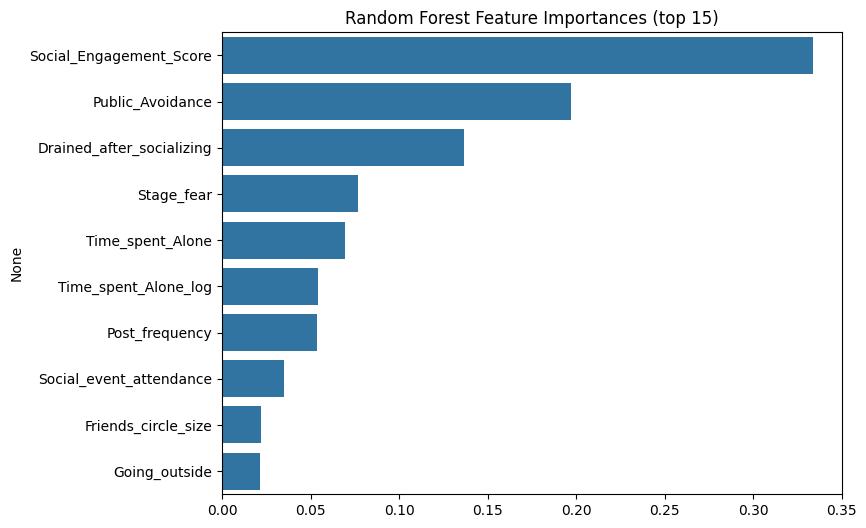

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(20))

# Plot top 15
plt.figure(figsize=(8,6))
sns.barplot(x=importances.head(15).values, y=importances.head(15).index)
plt.title('Random Forest Feature Importances (top 15)')
plt.show()

## 11. XGBoost (Final model)

### 🎯 Purpose

Train a powerful gradient-boosted model (XGBoost) to try to improve leaderboard score. Use CV for a baseline, then fit with early stopping on a train/validation split, create submission, and inspect feature importances.

### 1️⃣ Prepare data 

In [ ]:
# Features & target (already prepared earlier)
X = train_encoded.drop(columns=['id', 'Personality'])
y = train_encoded['Personality']

# Align test columns with train features
X_test = test_encoded.drop(columns=['id']).reindex(columns=X.columns)

### 2️⃣ CV baseline with XGBClassifier

In [247]:
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

print('XGB CV scores:', scores)
print('Mean XGB CV accuracy: %.4f (std %.4f)' % (scores.mean(), scores.std()))

XGB CV scores: [0.96842105 0.96680162 0.96545209 0.96950067 0.97084233]
Mean XGB CV accuracy: 0.9682 (std 0.0019)


### 3️⃣ Fit on Full Training Data and Predict on Test Set

In [ ]:
xgb.fit(X, y)

# Predict on test set
test_preds_xgb = xgb.predict(X_test)

# Check the first few predictions
print("Test predictions sample:", test_preds_xgb[:10])

Test predictions sample: [1 0 1 1 0 1 1 0 1 0]


### 4️⃣ Prepare Submission

In [257]:
# Map numeric predictions back to labels
test_preds_labels = np.where(test_preds_xgb == 1, 'Extrovert', 'Introvert')

# Prepare submission dataframe
submission_xgb = pd.DataFrame({
    'id': test_encoded['id'],
    'Personality': test_preds_labels
})

# Save to CSV
submission_xgb.to_csv('submission_xgboost.csv', index=False)
print("✅Submission file saved: submission_xgboost.csv")

✅Submission file saved: submission_xgboost.csv


### 5️⃣ Evaluate on Training Data 

Train Accuracy: 0.9772187432519974
Train F1 Score: 0.9846344305272356
Train ROC-AUC: 0.9682182013209996
Confusion Matrix:
 [[ 4581   244]
 [  178 13521]]


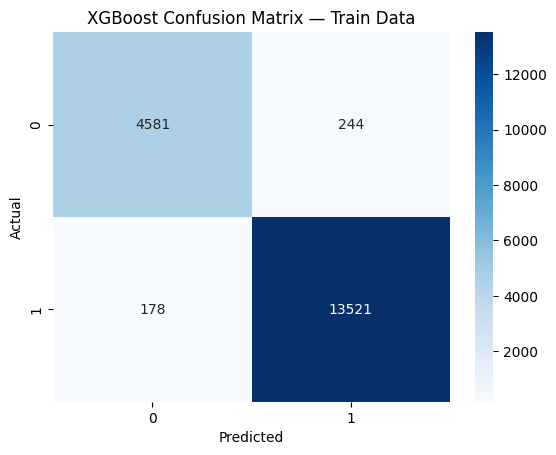

In [255]:
# Train predictions
train_preds_xgb = xgb.predict(X)

# Metrics
print('Train Accuracy:', accuracy_score(y, train_preds_xgb))
print('Train F1 Score:', f1_score(y, train_preds_xgb))
print('Train ROC-AUC:', roc_auc_score(y, train_preds_xgb))

# Confusion Matrix
cm = confusion_matrix(y, train_preds_xgb)
print('Confusion Matrix:\n', cm)

# Visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix — Train Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
